In [1]:
install.packages("UpSetR")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(hise)
library(dplyr)
library(reshape2)
library(tidyr)
library(limma)
library(pheatmap)
library(ggplot2)
library(gridExtra)
library(tibble)
library(plotly)
library(readxl)
library(VennDiagram)
library(stringr)
library(grid)
library(UpSetR)
library(data.table)
library(fgsea)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [123]:
Olink_processed_HC <- readRDS("/home/jupyter/formal_BRIanalysis/Olink_pathway_Mehul/Olink_processed_HC.rds")

## After loading RDS go here

In [124]:
remove_na_columns <- function(df) {
  df_no_nas <- df[, colSums(is.na(df)) == 0]
  return(df_no_nas)
}

In [125]:
Olink_processed_HC1 <- lapply(Olink_processed_HC, remove_na_columns)
Olink_processed_HC2 <- Filter(function(df) nrow(df) > 0 && ncol(df) > 0, Olink_processed_HC1)

In [126]:
combined_results <- c(Olink_processed_HC2)
common_columns <- Reduce(intersect, lapply(combined_results, names))
length(common_columns)

[1] 1433

In [127]:
to_remove <- c(
  "FMR1_OID21233",
  "HK2_OID20065",
  "STXBP3_OID21240",
  "MMP7_OID20087",
  "HNRNPK_OID20051",
  "WASF3_OID20882",
  "PTEN_OID20794",
  "CDC27_OID21238",
  "MTPN_OID20080",
  "STK24_OID20837",
  "CLTA_OID20118",
  "CALB2_OID20801",
  "PADI2_OID20467",
  "AKT3_OID21197",
  "LSM1_OID21210",
  "PAK4_OID20819",
  "SLC27A4_OID20814",
  "IMPA1_OID20907",
  "GSTP1_OID20876",
  "PDP1_OID21176",
  "RCOR1_OID20073",
  "STX16_OID21170",
  "ITGB1BP1_OID21268",
  "HLA-DRA_OID20520",
  "CNPY2_OID20069",
  "TIA1_OID20068",
  "BIRC2_OID21217",
  "ANXA11_OID20583"
)
result_to_remove <- str_extract(to_remove, "([^_]+)")

In [128]:
#remove possible markers identified by Lauren as technically dubious
common_columns <- setdiff(common_columns, result_to_remove)
length(common_columns)

[1] 1405

In [129]:
final_Olink_processed_HC <- lapply(Olink_processed_HC2, function(df) df[, common_columns, drop = FALSE])

## START ANALYSIS

#### LIMMA FIRST year 1 day 0 BR1 vs BR2

In [130]:
dataframe_names <- names(final_Olink_processed_HC)
print(dataframe_names)

 [1] "Flu Year 1 Day 0"              "Flu Year 1 Day 7"             
 [3] "Flu Year 1 Day 90"             "Flu Year 2 Day 0"             
 [5] "Flu Year 2 Day 7"              "Flu Year 1 Pre-Vac 7-12 Weeks"
 [7] "Flu Year 1 Stand-Alone"        "Flu Year 2 Day 90"            
 [9] "Flu Year 3 Day 0"              "Flu Year 3 Day 7"             
[11] "Flu Year 1 Pre-Vac 30 Days"    "Flu Year 2 Stand-Alone"       
[13] "Flu Year 3 Day 90"             "Flu Year 2 Pre-Vac 7-12 Weeks"
[15] "COVID-19 Visit 6"             


In [131]:
## Pick datasets that I would like to be analyzed together
#Use 'Flu Year 1 Day 0'

In [132]:
# Extracting the dataframes. Load all of them separately here. Easier to look at them one at a time later (normalize within timepoints to adjust for batch issues).
yr1_0 <- final_Olink_processed_HC$`Flu Year 1 Day 0`
yr1_7 <- final_Olink_processed_HC$`Flu Year 1 Day 7`
yr1_90 <- final_Olink_processed_HC$`Flu Year 1 Day 90`
yr2_0 <- final_Olink_processed_HC$`Flu Year 2 Day 0`
yr2_7 <- final_Olink_processed_HC$`Flu Year 2 Day 7`
yr2_90 <- final_Olink_processed_HC$`Flu Year 2 Day 90`
yr3_0 <- final_Olink_processed_HC$`Flu Year 3 Day 0`
yr3_7 <- final_Olink_processed_HC$`Flu Year 3 Day 7`
yr3_90 <- final_Olink_processed_HC$`Flu Year 3 Day 90`
yr1_prevac <- final_Olink_processed_HC$`Flu Year 1 Pre-Vac 7-12 Weeks`
yr2_prevac <- final_Olink_processed_HC$`Flu Year 2 Pre-Vac 7-12 Weeks`

In [133]:
#Check alignment
df_list <- list(yr1_0, yr1_7, yr1_90, yr2_0, yr2_7, yr2_90, yr1_prevac, yr2_prevac, yr3_0, yr3_7, yr3_90)

all_aligned <- all(sapply(2:length(df_list), function(i) identical(names(df_list[[i]]), names(df_list[[1]]))))
if(all_aligned) {
  print("Column names are aligned between all dataframes.")
} else {
  print("Column names are not aligned between all dataframes.")
}

[1] "Column names are aligned between all dataframes."


In [329]:
# Combine rows for limma
exprMatrix <- rbind(yr2_90)
exprMatrix <- t(exprMatrix)

In [330]:
#Load sample Info metadata
sampleInfo <- read.csv("/home/jupyter/formal_BRIanalysis/Olink_pathway_Mehul/sampleInfo2.csv")
rownames(sampleInfo) <- sampleInfo$SampleID
sampleInfo <- sampleInfo[,-1]
sampleInfo <- as.data.frame(sampleInfo)

In [331]:
main_meta_data <- read.csv("/home/jupyter/formal_BRIanalysis/DEG_Mehul/hise_meta_data_2024-01-23_fixed.csv")

In [332]:
# Subset and rename columns
selected_data <- main_meta_data[, c("subject.subjectGuid", "CMV.IgG.Serology.Result.Interpretation")]
names(selected_data) <- c("SampleID", "CMV_status")

# Check if all rows with the same SampleID have the same CMV_status
#The aggregate function is used to group the data by "SampleID". Within each group, it applies a function that checks if the length of unique "CMV_status" values is 1. If it's 1, it means all entries in that group have the same "CMV_status". The result in consistent_cmv_status will show TRUE for groups where the "CMV_status" is consistent across all entries and FALSE where it's not.
inconsistent_cmv <- aggregate(CMV_status ~ SampleID, data = selected_data, function(x) length(unique(x)) != 1)

# Filter to get only those SampleIDs where inconsistency exists
inconsistent_sample_ids <- inconsistent_cmv$SampleID[inconsistent_cmv$CMV_status]

# Display rows from original data where SampleID is in the list of inconsistent IDs
inconsistent_rows <- selected_data[selected_data$SampleID %in% inconsistent_sample_ids, ]

# View the result
inconsistent_rows
                              
                              #THERE ARE NO SAMPLES WHICH CHANGED CMV STATUS

SampleID,CMV_status
<chr>,<chr>


In [333]:
filtered_meta <- sampleInfo[sampleInfo$Group_2 %in% c("BR1", "BR2"), ]
filtered_meta <- filtered_meta[filtered_meta$Treatment %in% c("None"), ]

# Convert row names to a column
filtered_meta$SampleID <- rownames(filtered_meta)

In [334]:
#Add CMV_status from Q's metadata to my filtered dataset.
#this only works here because all samples don't change CMV status
# Collapse selected_data to have unique SampleID with first occurrence of CMV_status
selected_data_unique <- selected_data %>%
  group_by(SampleID) %>%
  slice(1) %>%
  ungroup()

# Merge sampleInfo with the unique selected_data
merged_data <- merge(filtered_meta, selected_data_unique, by = "SampleID", all.x = TRUE)

# Set SampleID as rownames and remove the SampleID column
rownames(merged_data) <- merged_data$SampleID

filtered_meta <- merged_data
head(filtered_meta)

,SampleID,Group,Group_2,Treatment,Cohort,Sex,Age,CMV_status
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
BR1001,BR1001,Good_control,BR1,None,BR1,Female,32,Negative
BR1002,BR1002,Good_control,BR1,None,BR1,Male,28,Negative
BR1003,BR1003,Good_control,BR1,None,BR1,Female,30,Negative
BR1004,BR1004,Good_control,BR1,None,BR1,Male,30,Negative
BR1005,BR1005,Good_control,BR1,None,BR1,Female,27,Negative
BR1006,BR1006,Good_control,BR1,None,BR1,Male,31,Negative


In [335]:
#Remove rows with CMV_status as NA. Should be only 2. This should be re-examined
filtered_meta <- na.omit(filtered_meta)

In [336]:
common_names <- intersect(colnames(exprMatrix), rownames(filtered_meta))
filtered_meta <- filtered_meta[common_names, ]
test.dat <- exprMatrix[, common_names]
design <- model.matrix(~ Group_2 + Sex + CMV_status, data = filtered_meta)
fit <- lmFit(test.dat, design)
fit <- eBayes(fit)
hits <- topTable(fit, coef = 2, p.value = 1, number = 20000)
hits <- as.data.frame(hits)

#filter for adjusted_p < 0.05
filtered_hits <- hits[hits$adj.P.Val < 0.05, ]
hits_STAT3vsCnt <- rownames(filtered_hits)
length(hits_STAT3vsCnt)

#filter for FC>0
pos_filtered_hits <- filtered_hits[filtered_hits$logFC > -50, ] #just take them all for now...
pos_hits_STAT3vsCnt <- rownames(pos_filtered_hits)
length(pos_hits_STAT3vsCnt)

#pos and negative hits
pos_hits <- filtered_hits[filtered_hits$logFC > -0, ]
pos_hits_good <- rownames(pos_hits)
length(pos_hits_good)
neg_hits <- filtered_hits[filtered_hits$logFC < -0, ]
neg_hits_good <- rownames(neg_hits)
length(neg_hits_good)

[1] 362

[1] 362

[1] 339

[1] 23

In [27]:
data <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/DEG_Analysis/MS_Sex_DEG_analysis/DEG_cohort_splitby_sex_CSVfiles/Age_yr1_Day0_Male/IL1B+ CD14 monocyte_Y1D0.csv")


In [76]:
data <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/DEG_Analysis/MS_Sex_DEG_analysis/DEG_cohort_splitby_sex_CSVfiles/Age_yr1_Day0_Female/IL1B+ CD14 monocyte_Y1D0.csv")


In [77]:
head(data)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,celltype,Direction,Year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,BCL2A1,34.515393,1.0146767,0.1737886,5.838570,5.265087e-09,0.0000108882,IL1B+ CD14 monocyte,BR2,Y1
2,PTGS2,18.262251,1.0483899,0.2195651,4.774848,1.798429e-06,0.0018595757,IL1B+ CD14 monocyte,BR2,Y1
3,NLRP3,8.916142,0.8007832,0.1789410,4.475124,7.636687e-06,0.0052642232,IL1B+ CD14 monocyte,BR2,Y1
4,RASGEF1B,12.182219,1.0262857,0.2352594,4.362359,1.286677e-05,0.0066521193,IL1B+ CD14 monocyte,BR2,Y1
5,IL1B,55.745095,1.1557310,0.2684734,4.304824,1.671182e-05,0.0069120094,IL1B+ CD14 monocyte,BR2,Y1
6,CMTM6,23.185185,0.4381138,0.1075105,4.075081,4.599836e-05,0.0140965154,IL1B+ CD14 monocyte,BR2,Y1


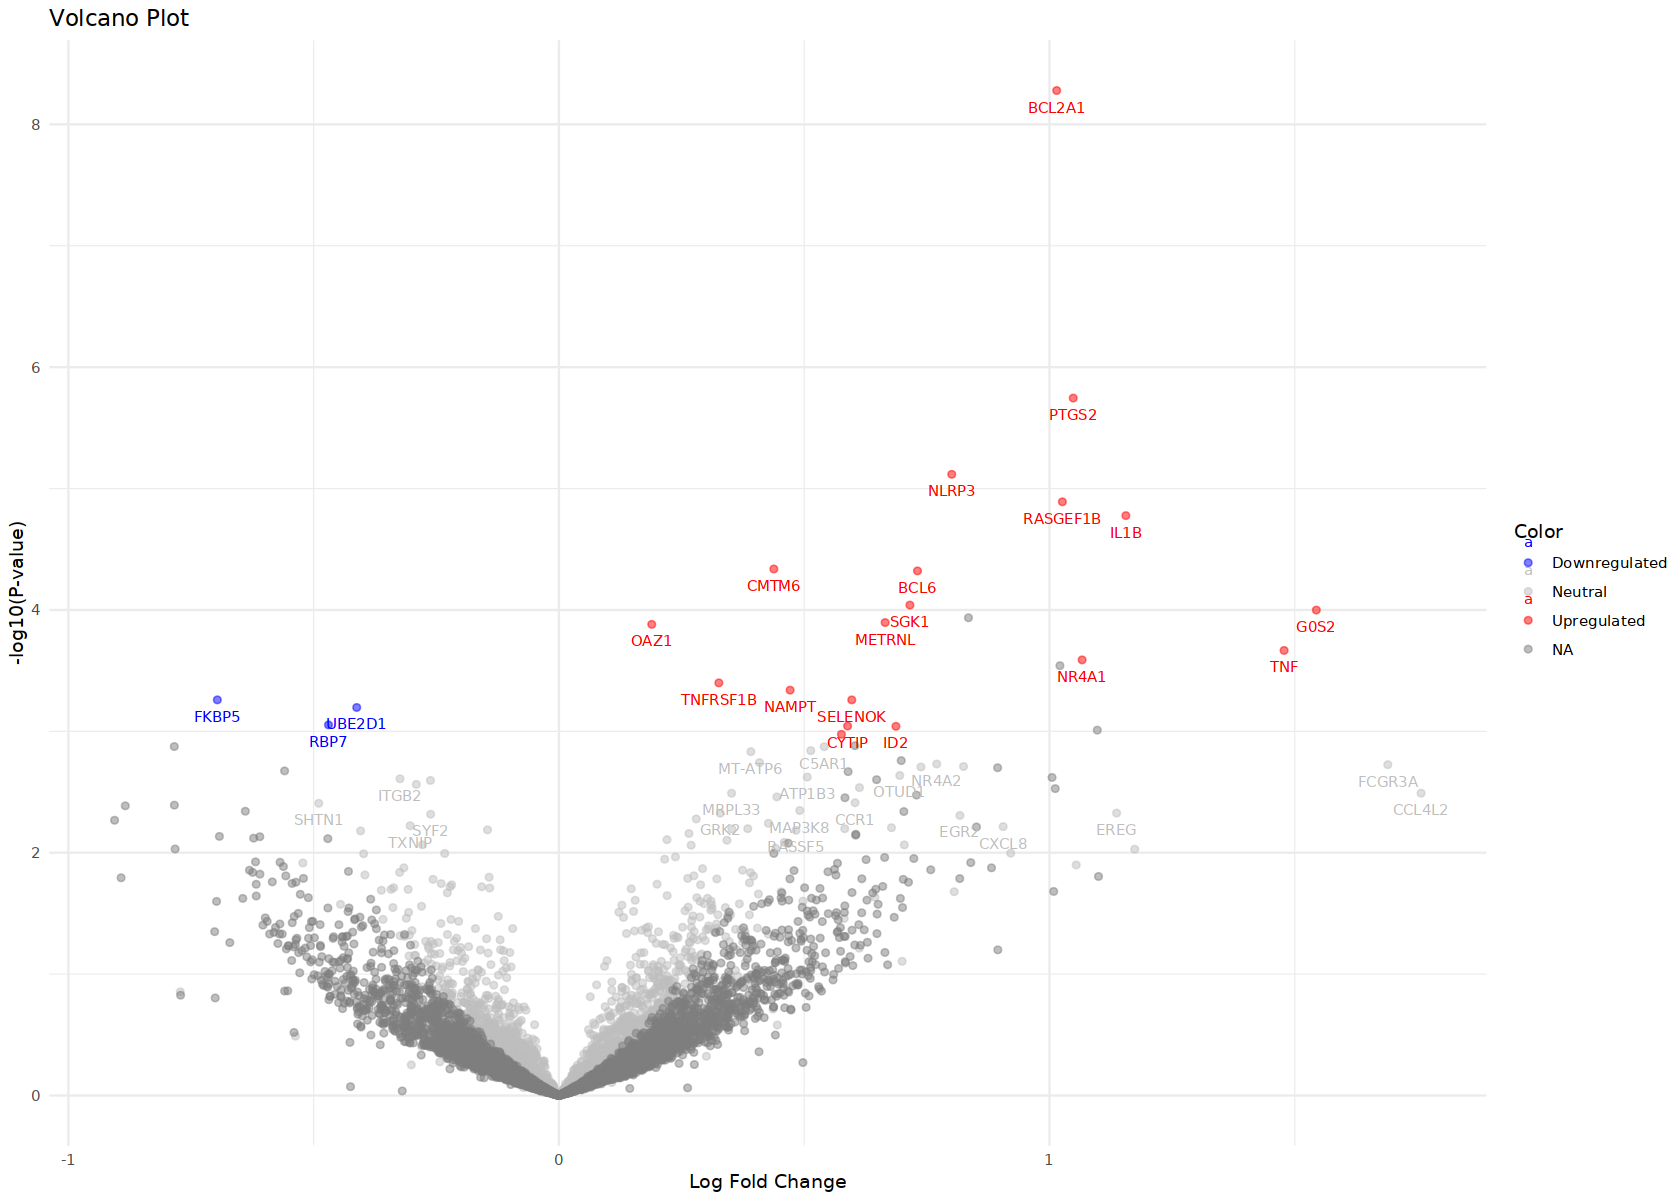

In [75]:
options(repr.plot.width=14, repr.plot.height=10) # Adjust these values as needed


# Classify genes based on fold change and adjusted P-value
data$Color <- ifelse(data$padj < 0.1, ifelse(data$log2FoldChange > 0, "Upregulated", "Downregulated"), "Neutral")


# Sorting data to find top 25 genes by P-value
top_genes <- data[order(data$padj),][1:50,]

# Volcano plot with top 25 genes labeled
ggplot(data, aes(x = log2FoldChange, y = -log10(pvalue), color = Color)) +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c("Downregulated" = "blue", "Upregulated" = "red", "Neutral" = "grey")) +
  geom_text(data = top_genes, aes(label = X), vjust = 2, hjust = 0.5, size = 3, check_overlap = TRUE) +
  theme_minimal() +
  labs(title = "Volcano Plot",
       x = "Log Fold Change",
       y = "-log10(P-value)")

In [338]:
pathways <- gmtPathways("/home/jupyter/formal_BRIanalysis/Olink_pathway_Mehul/hallamark.gmt")

In [339]:
ranked_genes <- setNames(hits$t, rownames(hits))

In [340]:
fgseaResults <- fgsea(pathways=pathways, stats=ranked_genes, minSize=5, maxSize=500)

In [341]:
significantPathways <- fgseaResults[fgseaResults$pval < 0.05,]

In [342]:
significantPathways

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
CHOLESTEROL_HOMEOSTASIS,0.032154341,0.29477994,0.2616635,0.6106075,1.432325,16,"TNFRSF12A, CXCL16 , S100A11 , PLAUR , LPL , LDLR , LGALS3 , ALCAM"
EPITHELIAL_MESENCHYMAL_TRANSITION,0.001446488,0.06943144,0.4550599,0.5190884,1.432514,84,"ACTA2 , FAS , PCOLCE , IGFBP4 , FSTL3 , CD59 , LGALS1 , TNFRSF12A, TIMP1 , COMP , TGFB1 , IL6 , IGFBP2 , LRP1 , PRSS2 , ITGAV , SFRP1 , MFAP5 , ITGB1 , VEGFA , CXCL8 , PLAUR , CDH2 , CCN1 , COL6A3 , TNFRSF11B, MMP1 , PVR , TGFBR3 , CDH6 , CAPG , ITGB5 , SPP1 , IL15 , NT5E , CCN2 , TFPI2 , VCAM1 , SCG2 , MATN2 , DCN , ITGA5"
IL6_JAK_STAT3_SIGNALING,0.005204550,0.08327280,0.4070179,0.5349568,1.417088,46,"FAS , REG1A , TNFRSF1A , TNFRSF12A, TNFRSF1B , TGFB1 , IL6 , ACVRL1 , CCL7 , OSMR , CXCL10 , CXCL9 , PLA2G2A , IL15RA , LTBR , CD14 , IFNGR1 , IL4R , TNFRSF21 , IL17RB , IL10RB , CSF1 , LEPR , CD38 , IL6ST , CSF2RA"
INFLAMMATORY_RESPONSE,0.028028028,0.29477994,0.2712886,0.4673038,1.278742,75,"F3 , ADM , TIMP1 , TNFRSF1B, IL6 , CCL2 , MSR1 , CCL7 , OSMR , CXCL10 , CD55 , CXCL9 , IL15RA , CXCL8 , PLAUR , CD14 , TNFSF10 , CLEC5A , LAMP3 , TNFRSF9 , LDLR , CX3CL1 , DCBLD2 , PVR , IL4R , CCL22 , OLR1 , CSF1 , IL15"
MYOGENESIS,0.036847492,0.29477994,0.2377938,0.5467202,1.384541,27,"TGFB1 , IGFBP7, AGRN , ITGB1 , MB , PLXNB2, LSP1 , FST , COL6A3"
TGF_BETA_SIGNALING,0.004011098,0.08327280,0.4070179,0.7376425,1.606412,11,"LTBP2 , CDH1 , TGFB1 , LEFTY2, FURIN"


In [343]:
df <- as.data.frame(significantPathways)
df <- setorder(df, -NES)
df <- as.data.frame(df)

In [344]:
# make a dataframe of the leading edge genes
cbind.fill <- function(...){
  nm <- list(...) 
  nm <- lapply(nm, as.matrix)
  n <- max(sapply(nm, nrow))
  do.call(cbind, lapply(nm, function (x) 
    rbind(x, matrix(, n-nrow(x), ncol(x)))))
}

pathways <- df$pathway
leadingEdges <- df$leadingEdge
dfList <- lapply(1:length(pathways), function(i) {
  data.frame(setNames(list(leadingEdges[[i]]), pathways[i]))
})
combinedDf <- do.call(cbind.fill, dfList)                    

In [345]:
combinedDf <- as.data.frame(combinedDf)

In [346]:
## SLEA function - from Aarthi Talla
# do SLEA (Sample Level Enrichment Analysis) function(z-score per sample)
doSLEA <- function(expressionSet, geneSet) {
  # scale expression
  exprsMat <- expressionSet
  exprsMat <- t(scale(t(exprsMat)))
  # extract expression of leGenes of each geneset
  comm <- intersect(geneSet, rownames(expressionSet))
  gsDF <- exprsMat[comm, ]
  # calculate mean expression per sample
  gsM <- colMeans(gsDF)
  # extract random markers of size of the geneSet from full probeset and calculate mean
  # and perform this for 'n' permutations
  nperm <- lapply(1:1000, function(j) {
    # set seed for every permutation
    set.seed(j)
    rGSDF <- exprsMat[sample.int(nrow(exprsMat),length(comm)), ]
    rGSM <- colMeans(rGSDF)
    return(value = rGSM)
  })
  permDF <- do.call(rbind, nperm)
  zscore <- (gsM - colMeans(permDF)) / apply(permDF,2,sd)
  sleaDF <- zscore %>% as.data.frame()
  return(value = sleaDF)
}

In [347]:
sleaLS1 <- lapply(1:length(combinedDf), function(l) {
  expressionSet = test.dat
  geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
  sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
  names(sDF) <- names(combinedDf[l])
  return(value = sDF)
})
sleaDF1 <- do.call(cbind, sleaLS1)
sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
head(sleaDF1)

,BR1012,BR1004,BR1011,BR2003,BR1008,BR1003,BR1002,BR1013,BR1007,BR1006,⋯,BR2046,BR1058,BR2029,BR1030,BR1059,BR1050,BR2026,BR1057,BR1041,BR1056
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TGF_BETA_SIGNALING,-2.132784,-1.915637,-0.7891633,-0.02441063,-0.8077490,-0.2681387,-2.278862,-2.290112,-1.675710,-3.16778230,⋯,0.9692409,-1.4738954,0.3111472,-0.8050239,-0.4709924,0.13876605,0.69000581,-0.6628439,-0.09705129,-0.8273237
EPITHELIAL_MESENCHYMAL_TRANSITION,-2.839501,-2.888755,-1.7923859,0.02474521,-2.4129307,-0.6289323,-3.102921,-4.960329,-2.558332,-3.57925490,⋯,4.9541794,-0.4840711,1.5821840,-0.5219022,-2.3958858,-0.41696090,3.28116673,0.2159037,-2.22801329,-1.1309714
CHOLESTEROL_HOMEOSTASIS,-1.127462,-2.630511,-0.8813987,1.71234997,-0.1915122,-1.4368674,-2.662058,-2.194477,-2.092411,-3.22910818,⋯,1.8105421,-1.1927565,0.6061703,0.1798227,1.3833004,0.07187561,-0.03221116,0.6115815,1.04000412,1.7420471
IL6_JAK_STAT3_SIGNALING,-1.428371,-4.347103,-0.5907551,-0.16714160,-2.5379288,0.3645071,-2.637303,-3.829581,-3.191088,-0.02104242,⋯,4.1630806,-1.0283931,-1.2392426,-0.8997803,-2.2189595,-2.19267491,3.39210300,0.8083358,-0.72566523,-1.5824316
MYOGENESIS,-1.252356,-1.319457,0.3932309,2.39758392,-0.4954753,-1.0993248,-1.697289,-2.474841,-1.163345,-0.93235381,⋯,1.8631165,-0.6254955,-0.8163009,0.1604304,-0.1627266,-0.64223149,2.29064618,-1.0773810,0.30868152,-0.2028974
INFLAMMATORY_RESPONSE,-1.915724,-2.937270,-1.2431677,0.70766879,-1.6136952,0.9529263,-4.089716,-2.210171,-3.686725,-2.39973986,⋯,3.3583735,-1.1753157,0.7733801,-0.4963470,-3.8491212,-1.92174724,2.34150546,-0.0867668,0.17984232,-0.6846389


In [348]:
cols <- colnames(sleaDF1)

# Separate columns based on prefix
br1_cols <- cols[grep("^BR1", cols)]
br2_cols <- cols[grep("^BR2", cols)]

# Combine the columns in the desired order
new_order <- c(br1_cols, br2_cols)

# Rearrange the dataframe
sleaDF1 <- sleaDF1[, new_order]

# Subset filtered_meta to match the column names in df_ordered
annotations <- filtered_meta[filtered_meta$SampleID %in% colnames(df_ordered), ]

# Create a subset with only Age, Sex and CMV annotations
annotations_subset <- filtered_meta[filtered_meta$SampleID %in% colnames(df_ordered), c("SampleID", "Age", "Sex", "CMV_status")]

# Order annotations in the same order as df_ordered columns
annotations_subset <- annotations_subset[match(colnames(sleaDF1), annotations_subset$SampleID), ]

# Define color palettes for annotations (adjust colors as per your data)
cohort_colors <- setNames(c("blue", "red"), unique(annotations$Cohort))
sex_colors <- setNames(c("pink", "lightblue"), unique(annotations$Sex))

# Combine color mappings into a list
annotation_colors <- list(Cohort = cohort_colors, Sex = sex_colors)

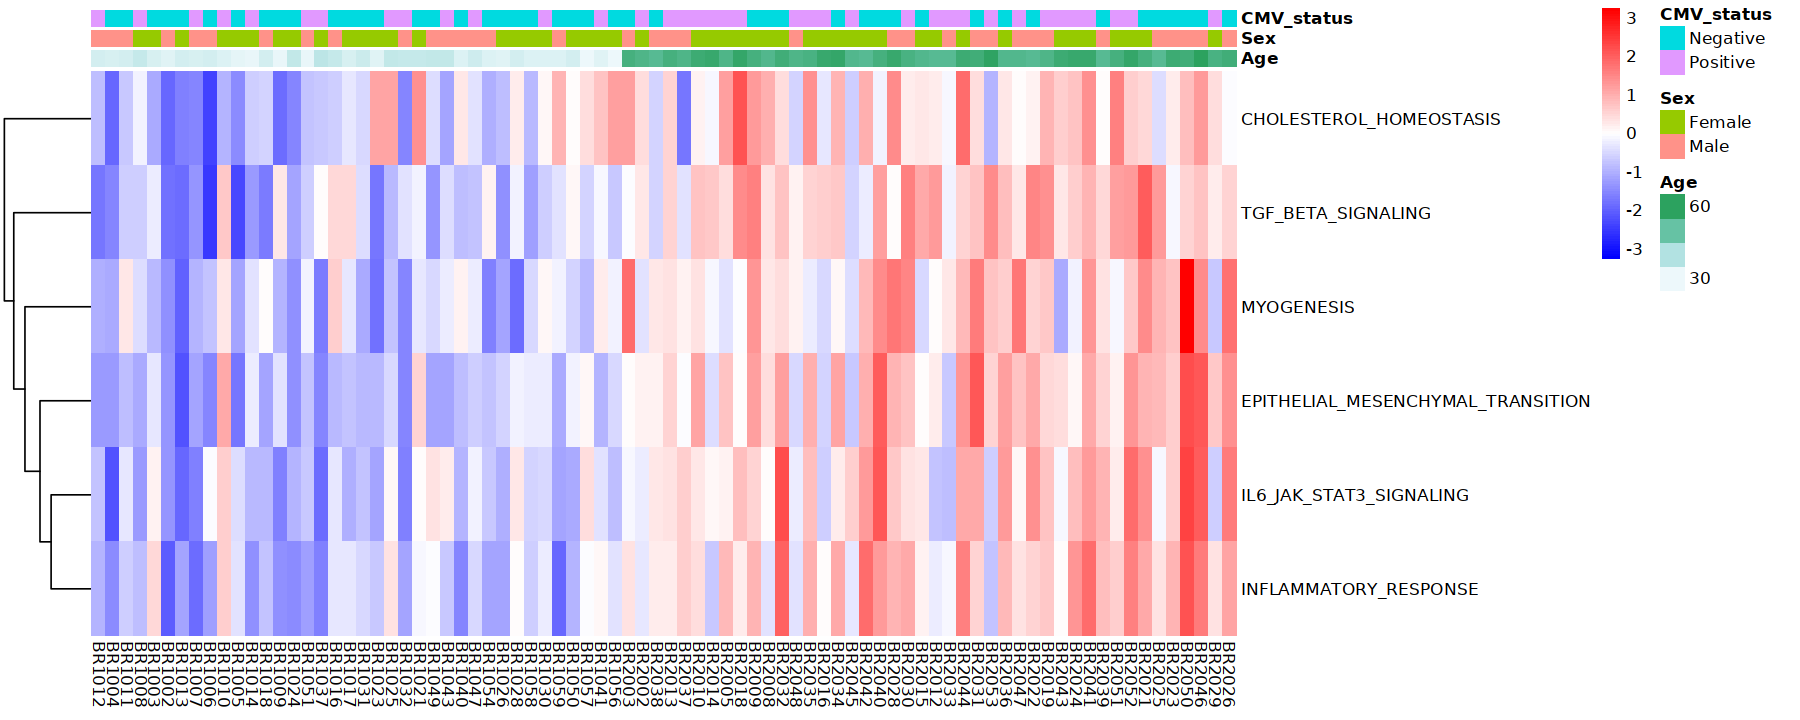

In [349]:
options(repr.plot.width=15, repr.plot.height=6) # Adjust these values as needed

# Define a color palette
color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

# Create the heatmap
pheatmap(sleaDF1, 
         clustering_distance_cols = "none", # Disable column clustering
         clustering_distance_rows = "euclidean", # Default row clustering
         cluster_cols = FALSE, # Keep columns in the same order
         color = color_palette, # Use the defined color palette
         scale = "row",
         annotation_col = annotations_subset[, -1]# Scale rows to have 0 mean and 1 standard deviation
)

In [350]:
options(repr.plot.width=8, repr.plot.height=4) # Adjust these values as needed

# Subset for genes of interest
genes_of_interest <- c("TGFB1", "CXCL17", "ACTA2", "PCOLCE") # Replace with any genes
df_subset <- test.dat[rownames(test.dat) %in% genes_of_interest, ]

# Order columns by BR1 and BR2
cols <- colnames(df_subset)
br1_cols <- cols[grep("^BR1", cols)]
br2_cols <- cols[grep("^BR2", cols)]
new_order <- c(br1_cols, br2_cols)
df_ordered <- df_subset[, new_order]

# Subset filtered_meta to match the column names in df_ordered
annotations <- filtered_meta[filtered_meta$SampleID %in% colnames(df_ordered), ]

# Create a subset with only Age, Sex and CMV annotations
annotations_subset <- filtered_meta[filtered_meta$SampleID %in% colnames(df_ordered), c("SampleID", "Age", "Sex", "CMV_status")]

# Order annotations in the same order as df_ordered columns
annotations_subset <- annotations_subset[match(colnames(df_ordered), annotations_subset$SampleID), ]

# Define color palettes for annotations (adjust colors as per your data)
cohort_colors <- setNames(c("blue", "red"), unique(annotations$Cohort))
sex_colors <- setNames(c("pink", "lightblue"), unique(annotations$Sex))

# Combine color mappings into a list
annotation_colors <- list(Cohort = cohort_colors, Sex = sex_colors)

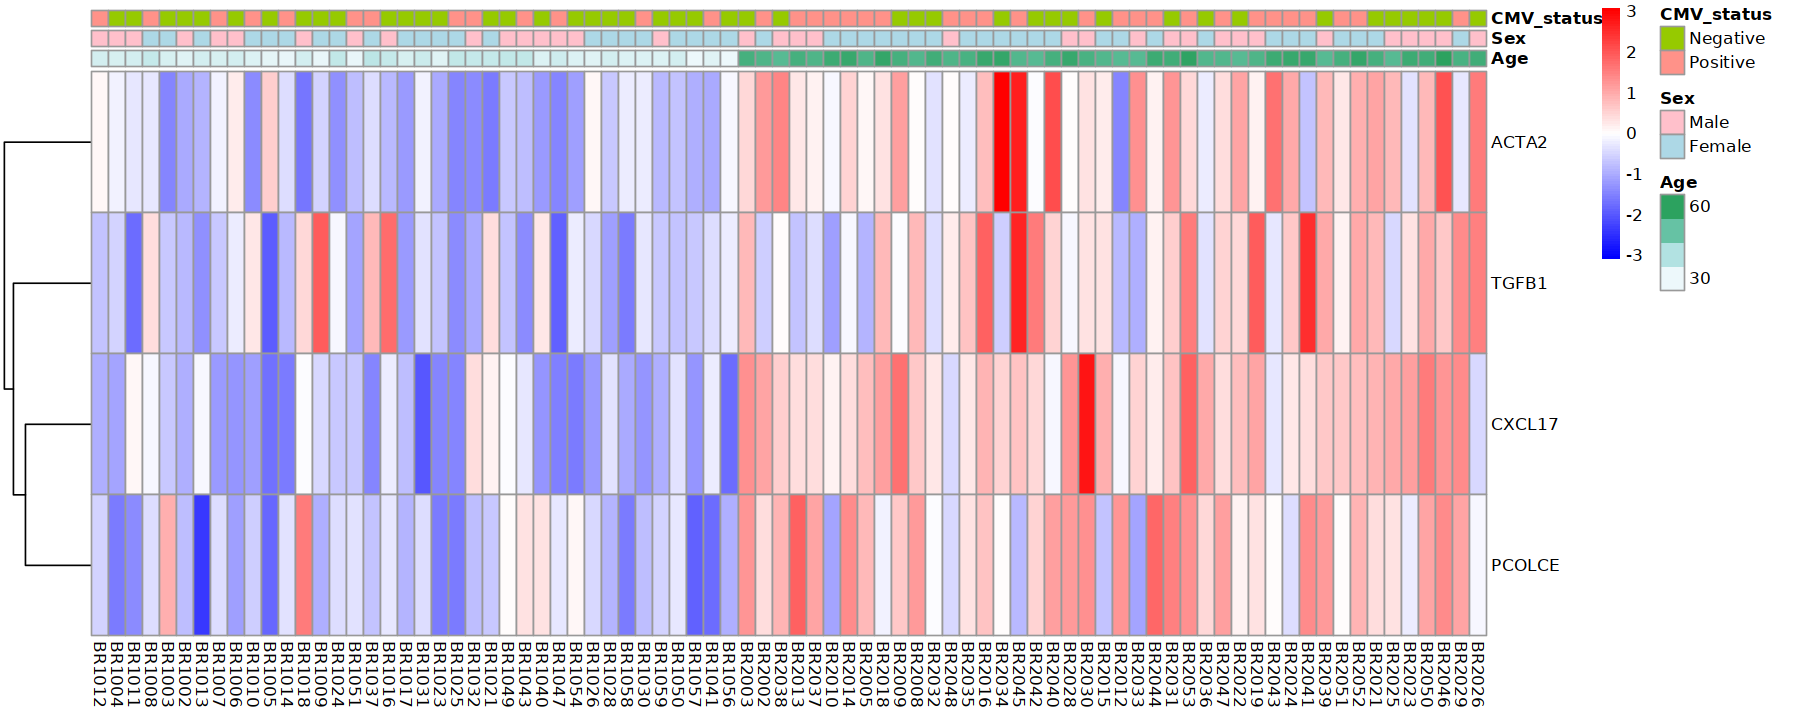

In [351]:
options(repr.plot.width=15, repr.plot.height=6)

# Plot the heatmap with annotations
pheatmap(df_ordered, 
         clustering_distance_cols = "none", 
         cluster_cols = FALSE, 
         color = color_palette,
         scale = "row",
         annotation_col = annotations_subset[, -1],
         annotation_colors = annotation_colors
)